Last updated on May 16, 2023

# Demo script for generating local wave activity plots from ERA5 data

This is a complimentary demo script that can be used to implement the local wave activity, fluxes and flux convergence/divergence computation required in the analyses presented in Nakamura and Huang, Atmospheric Blocking as a Traffic Jam in the Jet Stream. Science. (2018)

This notebook demonstrate how to compute local wave activity and all the flux terms in equations (2) and (3) in NH2018 with the updated functionality in the python package `hn2016_falwa`. To run the script, please install the 
package `hn2016_falwa` using
```
python setup.py develop
```
after cloning the [GitHub repo](http://github.com/csyhuang/hn2016_falwa).

The functionalities are enhanced and included in the class object `QGField` under `hn2016_falwa.oopinterface`. Please refer to the [documentation](http://hn2016-falwa.readthedocs.io/) (search `QGField`) or the end of this notebook for the input/methods this class provides.

Please [raise an issue in the GitHub repo](https://github.com/csyhuang/hn2016_falwa/issues) or contact Clare S. Y. Huang (csyhuang@uchicago.edu) if you have any questions or suggestions regarding the package.

In [1]:
import os
from math import pi
import datetime as dt

import numpy as np
from numpy import dtype
from netCDF4 import Dataset
import matplotlib.pyplot as plt

%matplotlib inline
from falwa.oopinterface import QGField
import falwa.utilities as utilities


# Load ERA5 data retrieved

In [2]:
# --- Load zonal wind, meridional wind, and temperature at pressure levels --- #
u_file = Dataset("2012-10-29-to-2012-10-31_era5_u.nc", mode='r')
v_file = Dataset("2012-10-29-to-2012-10-31_era5_v.nc", mode='r')
t_file = Dataset("2012-10-29-to-2012-10-31_era5_t.nc", mode='r')

time_array = u_file.variables['time'][:]
time_units = u_file.variables['time'].units
time_calendar = u_file.variables['time'].calendar
ntimes = time_array.shape[0]

print(u_file)
print('Dimension of time: {}'.format(time_array.size))

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-05-16 21:02:22 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data7/adaptor.mars.internal-1684270942.0645149-28668-7-5cdb6ad3-e708-4731-aba1-b95e05c395f1.nc /cache/tmp/5cdb6ad3-e708-4731-aba1-b95e05c395f1-adaptor.mars.internal-1684270936.3461807-28668-15-tmp.grib
    dimensions(sizes): longitude(360), latitude(181), level(37), time(6)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 level(level), int32 time(time), int16 u(time, level, latitude, longitude)
    groups: 
Dimension of time: 6


# Load the dimension arrays
In this version, the `QGField` object takes only:
- latitude array in degree ascending order, and 
- pressure level in hPa in decending order (from ground to aloft).

In [3]:
xlon = u_file.variables['longitude'][:].data

# latitude has to be in ascending order
ylat = u_file.variables['latitude'][:].data
if np.diff(ylat)[0]<0:
    print('Flip ylat.')
    ylat = ylat[::-1]

# pressure level has to be in descending order (ascending height)
plev = u_file.variables['level'][:].data
if np.diff(plev)[0]>0:
    print('Flip plev.')    
    plev = plev[::-1]

nlon = xlon.size
nlat = ylat.size
nlev = plev.size

Flip ylat.
Flip plev.


In [4]:
clat = np.cos(np.deg2rad(ylat))     # cosine latitude
p0 = 1000.                          # surface pressure [hPa]
height = np.arange(0,48001,1000)    # pseudoheight [m]
dz = 1000.                          # differential height element
dphi = np.diff(ylat)[0]*pi/180.     # differential latitudinal element
dlambda = np.diff(xlon)[0]*pi/180.  # differential latitudinal element
hh = 7000.                          # scale height
cp = 1004.                          # heat capacity of dry air
rr = 287.                           # gas constant
omega = 7.29e-5                     # rotation rate of the earth
aa = 6.378e+6                       # earth radius
kmax = 49                           # number of grid points for vertical extrapolation (dimension of height)
prefactor = 6500.                   # integrated sum of density from ground to aloft
npart = nlat                        # number of partitions to construct the equivalent latitude grids
maxits = 100000                     # maximum number of iteration in the SOR solver to solve for reference state
tol = 1.e-5                         # tolerance that define convergence of solution
rjac = 0.95                         # spectral radius of the Jacobi iteration in the SOR solver.              
jd = nlat//2+1                      # (one plus) index of latitude grid point with value 0 deg
                                    # This is to be input to fortran code. The index convention is different.


# Set the level of pressure and the timestamp to display below

In [5]:
tstamp = [dt.datetime(1900, 1, 1) + dt.timedelta(hours=int(hrs)) for hrs in time_array.data]
plev_selected = 10 # selected pressure level to display
tstep_selected = 0 # selected time step to display

In [6]:
# Initialize empty array for data storage

qgpv = np.empty((ntimes, kmax, nlat, nlon))
interpolated_u = np.empty((ntimes, kmax, nlat, nlon))
interpolated_v = np.empty((ntimes, kmax, nlat, nlon))
interpolated_theta = np.empty((ntimes, kmax, nlat, nlon))
qref = np.empty((ntimes, kmax, nlat))
uref = np.empty((ntimes, kmax, nlat))
ptref = np.empty((ntimes, kmax, nlat))
adv_flux_f1 = np.empty((ntimes, nlat, nlon))
adv_flux_f2 = np.empty((ntimes, nlat, nlon))
adv_flux_f3 = np.empty((ntimes, nlat, nlon))
adv_flux_conv = np.empty((ntimes, nlat, nlon))
divergence_eddy_momentum_flux = np.empty((ntimes, nlat, nlon))
meridional_heat_flux = np.empty((ntimes, nlat, nlon))
lwa_baro = np.empty((ntimes, nlat, nlon))
u_baro = np.empty((ntimes, nlat, nlon))
lwa = np.empty((ntimes, kmax, nlat, nlon))

# Loop through the input file and store all the computed quantities in a netCDF file

In [7]:
for tstep in range(ntimes):
    
    uu = u_file.variables['u'][tstep, ::-1, ::-1, :].data
    vv = v_file.variables['v'][tstep, ::-1, ::-1, :].data
    tt = t_file.variables['t'][tstep, ::-1, ::-1, :].data

    qgfield_object = QGField(xlon, ylat, plev, uu, vv, tt, northern_hemisphere_results_only=True)

    qgpv[tstep, :, :, :], interpolated_u[tstep, :, :, :], interpolated_v[tstep, :, :, :], \
        interpolated_theta[tstep, :, :, :], static_stability = qgfield_object.interpolate_fields()

    qref[tstep, :, (nlat//2):], uref[tstep, :, (nlat//2):], ptref[tstep, :, (nlat//2):] = \
        qgfield_object.compute_reference_states()

    adv_flux_f1[tstep, (nlat//2):, :], \
    adv_flux_f2[tstep, (nlat//2):, :], \
    adv_flux_f3[tstep, (nlat//2):, :], \
    adv_flux_conv[tstep, (nlat//2):, :], \
    divergence_eddy_momentum_flux[tstep, (nlat//2):, :], \
    meridional_heat_flux[tstep, (nlat//2):, :], \
    lwa_baro[tstep, (nlat//2):, :], \
    u_baro[tstep, (nlat//2):, :], \
    lwa[tstep, :, (nlat//2):, :] \
        = qgfield_object.compute_lwa_and_barotropic_fluxes()    


Do scipy interpolation


  1861865104           0           4  converged at n =         1647
line 748: ncforce is None


 nd:           91 , jb:            0


Do scipy interpolation
  1861865104           0           4  converged at n =         1667
line 748: ncforce is None


 nd:           91 , jb:            0


Do scipy interpolation
  1861865104           0           4  converged at n =         1657
line 748: ncforce is None


 nd:           91 , jb:            0


Do scipy interpolation
  1861865104           0           4  converged at n =         1674
line 748: ncforce is None


 nd:           91 , jb:            0


Do scipy interpolation
  1861865104           0           4  converged at n =         1687
line 748: ncforce is None


 nd:           91 , jb:            0


Do scipy interpolation
  1861865104           0           4  converged at n =         1693
line 748: ncforce is None
 nd:           91 , jb:            0


In [8]:
# Set color scales
lwa_max = lwa[:, plev_selected, (nlat//2)+16:-1, :].max()
lwa_min = 0.0
lwa_cscale = np.linspace(lwa_min, lwa_max, 51, endpoint=True)
print(f"lwa_min = {lwa_min}, lwa_max = {lwa_max}")

qgpv_max = qgpv[:, plev_selected, (nlat//2)+16:-1, :].max()
qgpv_min = qgpv[:, plev_selected, (nlat//2)+16:-1, :].min()
print(f"qgpv_min = {qgpv_min}, qgpv_max = {qgpv_max}")
qgpv_cscale = np.linspace(qgpv_min, qgpv_max, 51, endpoint=True)

lwa_min = 0.0, lwa_max = 343.5131530761719
qgpv_min = -0.00013417017180472612, qgpv_max = 0.0006000221474096179


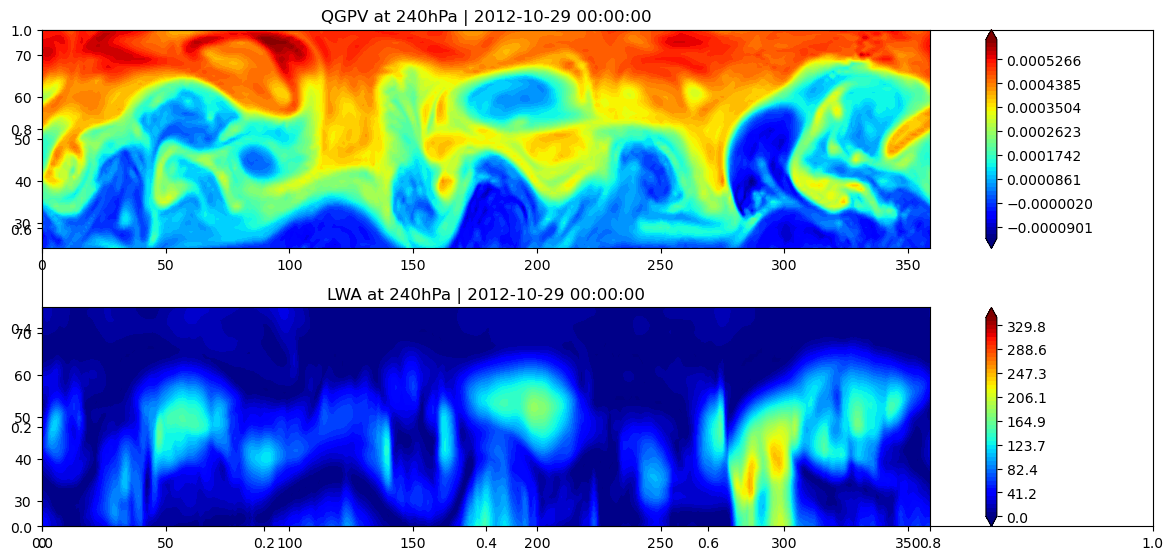

tstep = 1/6



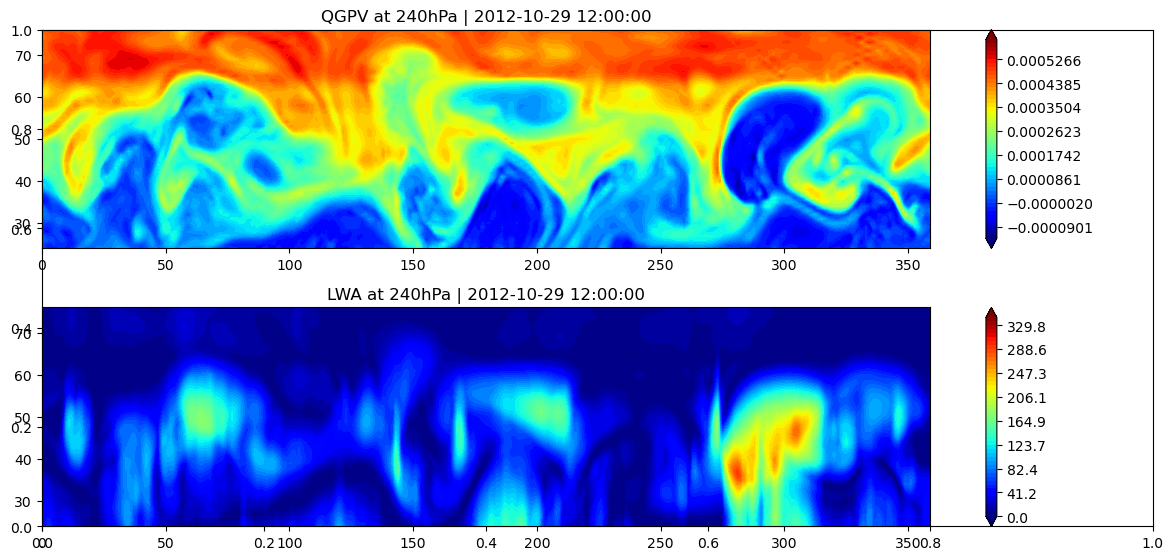

tstep = 2/6



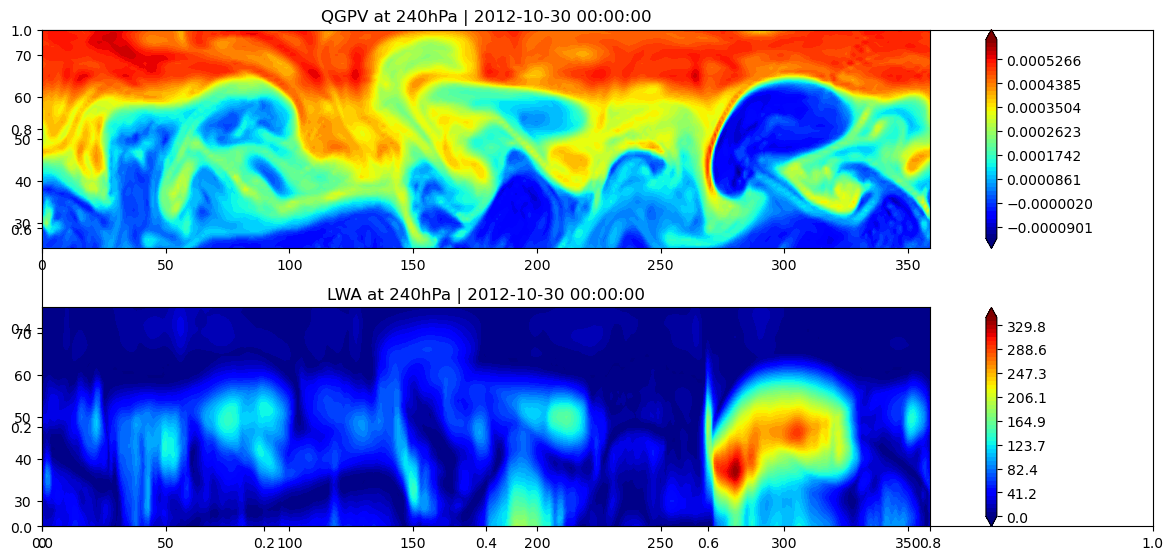

tstep = 3/6



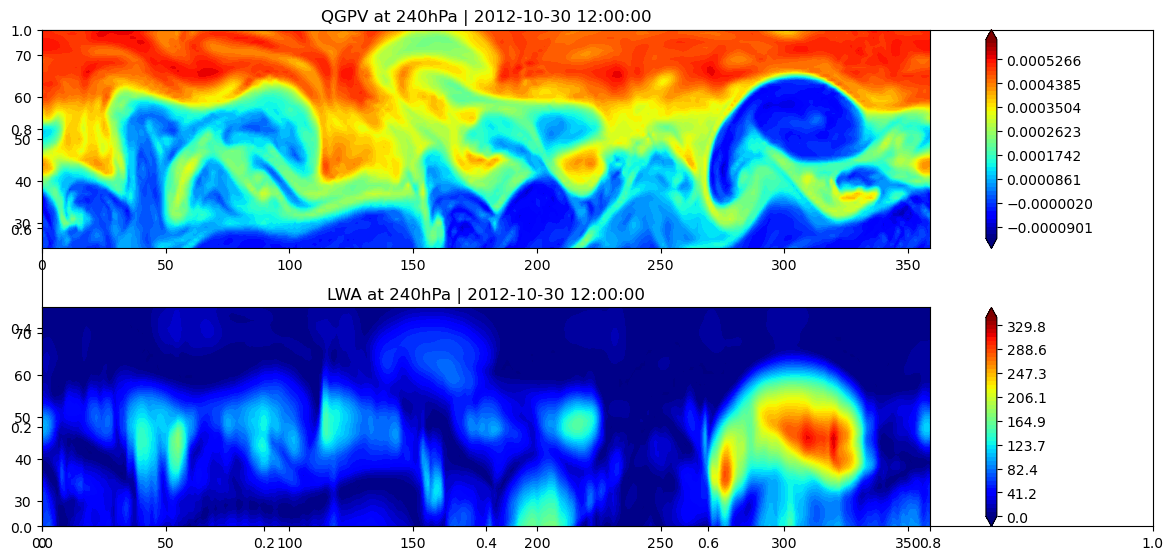

tstep = 4/6



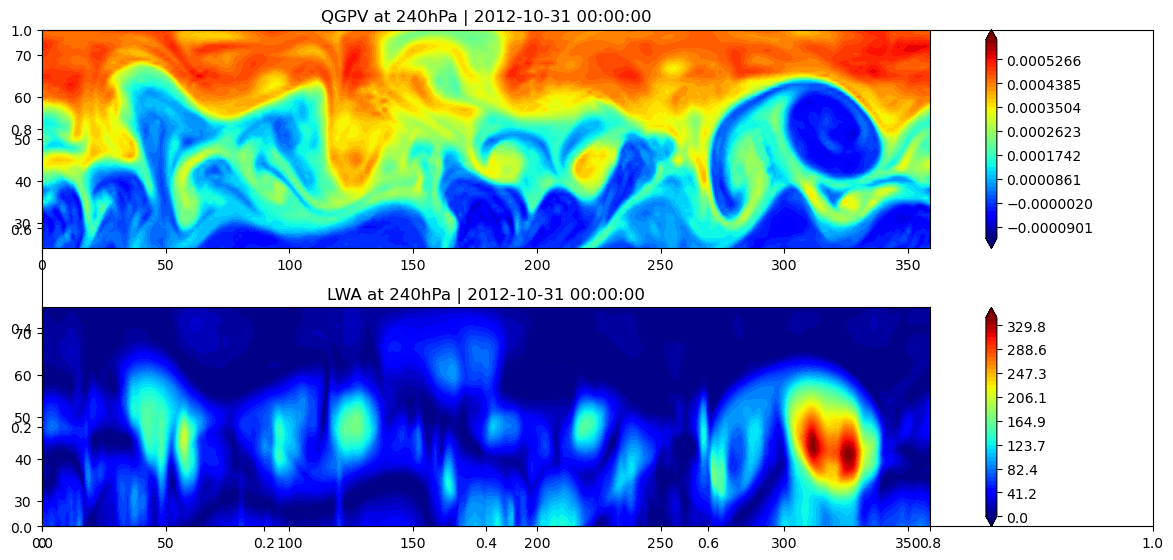

tstep = 5/6



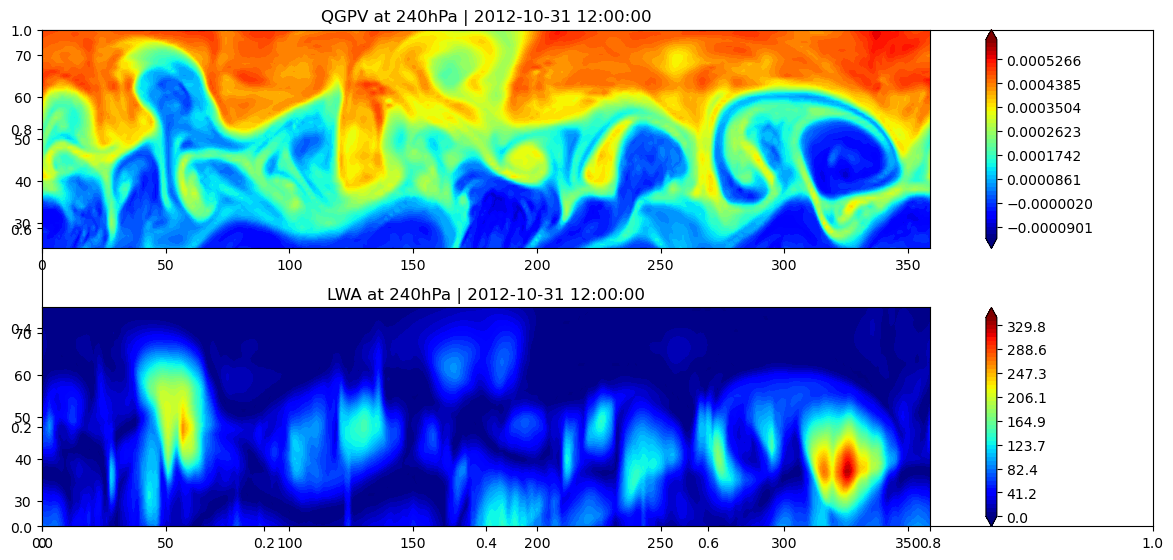

tstep = 6/6



In [9]:
for tstep in range(ntimes):
    plt.subplots(figsize=(12,6))
    # *** QGPV at 240 hPa ***
    plt.subplot(211)
    plt.contourf(xlon, ylat[(nlat//2):-1], qgpv[tstep, plev_selected, (nlat//2):-1, :], qgpv_cscale, cmap='jet', extend="both")
    plt.colorbar()
    plt.ylim(24, 76)
    plt.title('QGPV at 240hPa | ' + str(tstamp[tstep]))
    # *** LWA at 240 hPa ***
    plt.subplot(212)
    plt.contourf(xlon, ylat[(nlat//2):-1], lwa[tstep, plev_selected, (nlat//2):-1, :], lwa_cscale, cmap='jet', extend="both")
    plt.colorbar()
    plt.ylim(24, 76)
    plt.title('LWA at 240hPa | ' + str(tstamp[tstep]))
    plt.tight_layout()
    plt.show()
    print('tstep = {}/{}\n'.format(tstep + 1, ntimes))
